In [10]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

import torch, torchvision
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader

from customized_dataloader import CustomDataset,customsampler

In [2]:
df = pd.read_csv("final_df.csv")

df.loc[df['Contrast']==True,['Contrast']] = 1
df.loc[df['Contrast']==False,['Contrast']] = 0

df['Contrast'] = df['Contrast'].astype('int')

train_images = df['dicom_name'].values
train_labels = df['Contrast'].values

In [3]:
dataset = CustomDataset(train_images, train_labels)
sampler = customsampler(train_labels, 1,1)
dataloader = DataLoader(dataset, batch_size=2,sampler=sampler)

total_batch = len(dataloader)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
vgg16 = models.vgg16(pretrained=True)

In [6]:
vgg16.features[0] = nn.Conv2d(1,64, kernel_size=(3,3))

vgg16.classifier[3] = nn.Linear(4096,512)
vgg16.classifier[6] = nn.Linear(512,1)

model = nn.Sequential(
        vgg16,
        nn.Sigmoid()
        )

model.to(device)

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxPool2d(kernel_

In [12]:
model.train()
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

loss_values = []

epoch = 10

for i in range(epoch):
    avg_cost = 0.0
    for e, data in enumerate(dataloader):

        image, label = data
        image = image.reshape(2,512,512,1) #채널수가 흑백=>마지막에 1
        
        image = image.permute(0,3,1,2) #batch, channel, width, height 순으로 텐서 변경
        
        image = image.to(device)
        label = label.to(device)
        
        image.requires_grad = True
    
        optimizer.zero_grad()

        outputs = model(image)

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        avg_cost += loss / total_batch
        
    print(f'[Epoch:{i + 1}] cost = {avg_cost}')
    loss_values.append(avg_cost.item())
    
print('Learning Finished!')
        
    

[Epoch:1] cost = 50.0
[Epoch:2] cost = 50.0
[Epoch:3] cost = 50.0
[Epoch:4] cost = 50.0
[Epoch:5] cost = 50.0
[Epoch:6] cost = 50.0
[Epoch:7] cost = 50.0
[Epoch:8] cost = 50.0
[Epoch:9] cost = 50.0
[Epoch:10] cost = 50.0
Learning Finished!


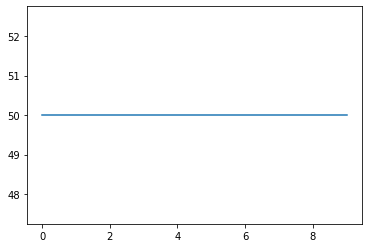

In [13]:
plt.plot(loss_values)

In [23]:
torch.cuda.empty_cache()